In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import os
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('all_stocks_5yr.csv', delimiter=',', on_bad_lines='skip')
print(data.shape)
print(data.sample(7))

(619040, 7)
              date    open    high     low   close   volume  Name
441575  2014-02-13   39.95   40.52   39.53   40.39   874715  PDCO
204194  2016-12-29  227.80  230.69  226.94  229.52   342688   ESS
368870  2013-05-29   67.15   67.65   66.50   67.21   957712   MCO
590188  2013-04-03   42.73   42.73   42.33   42.50   944247   WEC
257107  2016-03-29   39.10   39.65   38.58   39.49   501150  GRMN
451236  2017-06-27   24.18   24.40   24.01   24.07  7175042   PHM
122358  2015-02-09   69.13   69.41   68.90   69.07  2112995    CL


In [6]:
data['date'] = pd.to_datetime(data['date'])
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 619040 entries, 0 to 619039
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    619040 non-null  datetime64[ns]
 1   open    619029 non-null  float64       
 2   high    619032 non-null  float64       
 3   low     619032 non-null  float64       
 4   close   619040 non-null  float64       
 5   volume  619040 non-null  int64         
 6   Name    619040 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 33.1+ MB


,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL


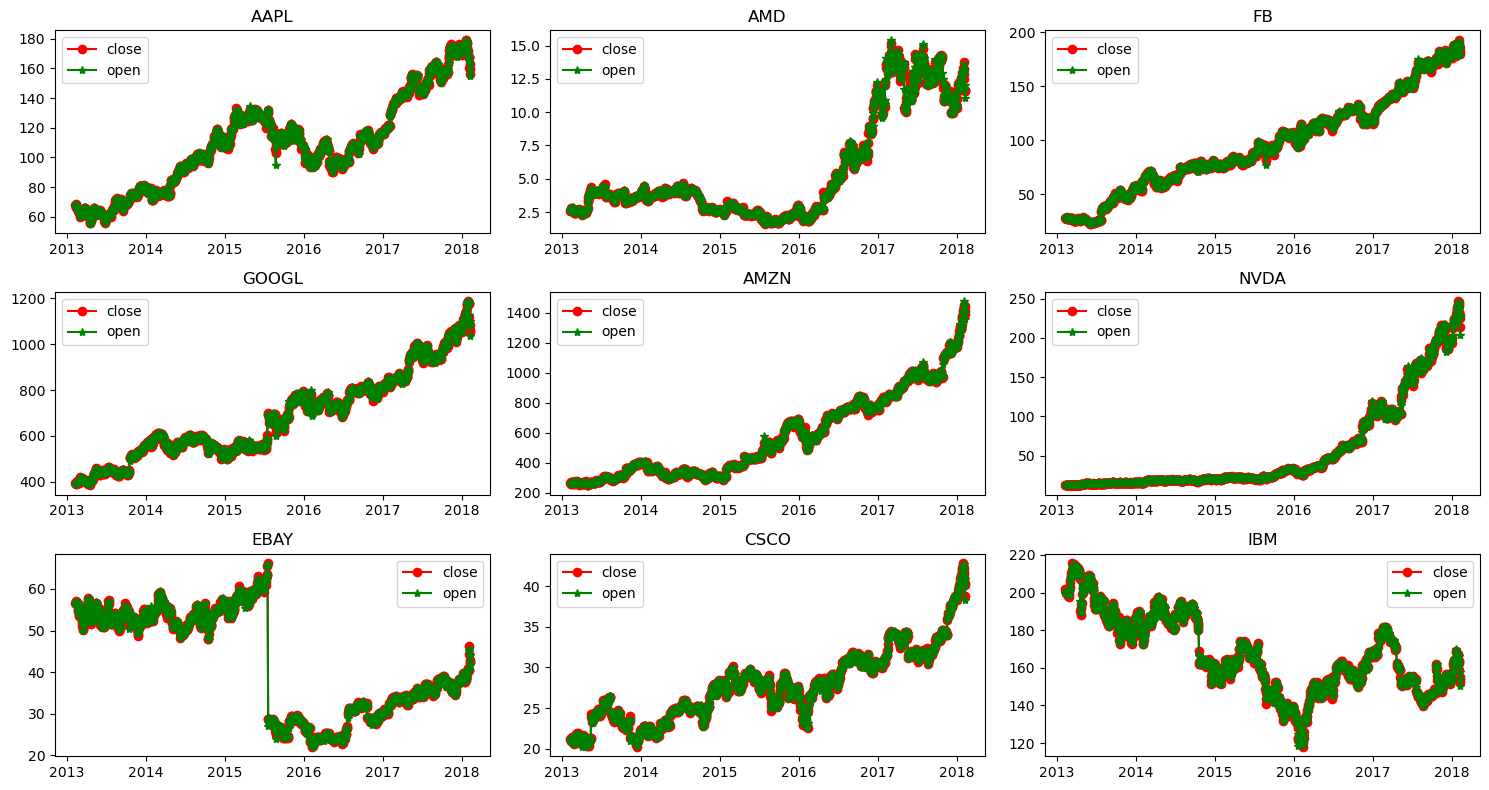

In [16]:
companies = ['AAPL', 'AMD', 'FB', 'GOOGL', 'AMZN', 'NVDA', 'EBAY', 'CSCO', 'IBM']

plt.figure(figsize=(15,8))
for index, company in enumerate(companies,1):
    plt.subplot(3,3, index)
    c = data[data['Name'] == company]
    plt.plot(c['date'], c['close'], c='r', label='close', marker='o')
    plt.plot(c['date'], c['open'], c='g', label='open', marker="*")
    plt.title(company)
    plt.legend()
    plt.tight_layout()
    

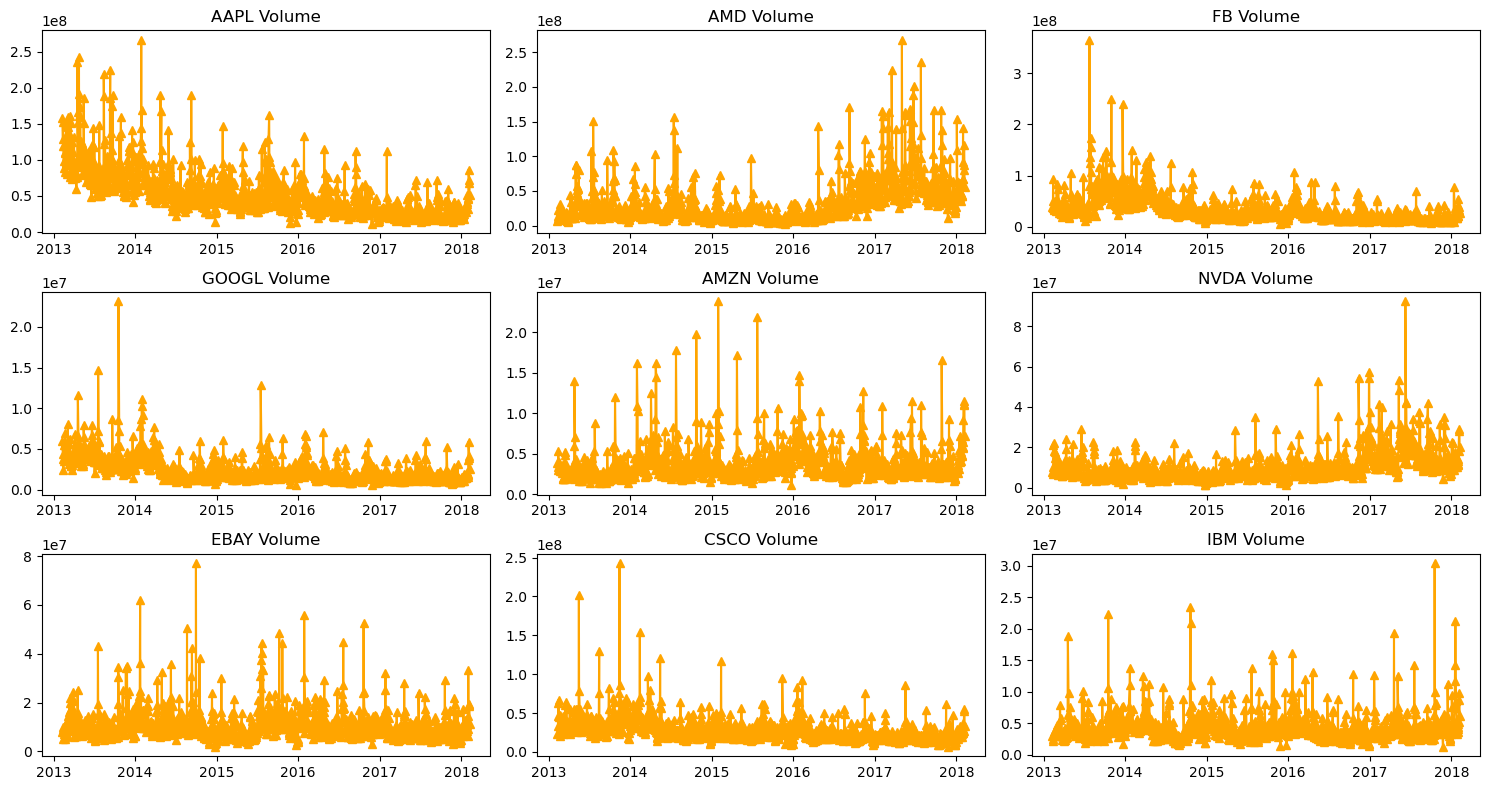

In [24]:
plt.figure(figsize=(15,8))
for index, company in enumerate(companies, 1):
    plt.subplot(3,3,index)
    c = data[data['Name'] == company]
    plt.plot(c['date'], c['volume'], c='orange',marker="^")
    plt.title(f"{company} Volume")
    plt.tight_layout()

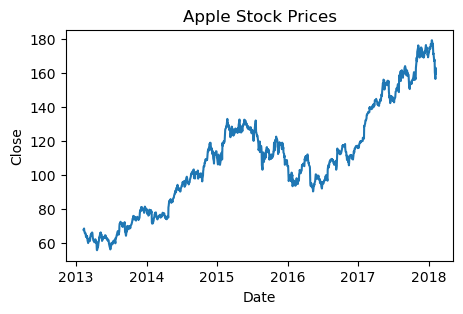

In [23]:
plt.figure(figsize=(5, 3))
apple = data[data['Name'] == 'AAPL']
prediction_range = apple.loc[(apple['date'] > datetime (2013, 1, 1)) & (apple['date'] < datetime(2018, 1, 1))]
plt.plot(apple['date'], apple['close'])
plt.xlabel("Date")
plt.ylabel("Close")
plt.title("Apple Stock Prices")
plt.show()

In [26]:
close_data = apple.filter(['close'])
dataset = close_data.values
training = int(np.ceil(len(dataset)* .95))
print("Training data length:",training)

Training data length: 1197


In [30]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

train_data = scaled_data[0:int(training), :]
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [39]:
model = keras.models.Sequential()
model.add(keras.layers.LSTM(units=64,
                            return_sequences=True,
                            input_shape=(x_train.shape[1], 1)))
model.add(keras.layers.LSTM(units=64))
model.add(keras.layers.Dense(32))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1))
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 60, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,033 (203.25 KB)

 Trainable params: 52,033 (203.25 KB)

 Non-trainable params: 0 (0.00 B)

In [47]:
model.compile(optimizer='adam',
              loss='mean_squared_error')
history = model.fit(x_train,
                    y_train,
                    epochs=10)

Epoch 1/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - loss: 0.0041
Epoch 2/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0037
Epoch 3/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0038
Epoch 4/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0036
Epoch 5/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0032
Epoch 6/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - loss: 0.0026
Epoch 7/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.0027
Epoch 8/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0028
Epoch 9/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0026
Epoch 10/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0024


In [48]:
test_data = scaled_data[training - 60:, :]
x_test = []
y_test = dataset[training:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

mse = np.mean(((predictions - y_test) ** 2))
rmse = np.sqrt(mse)

print("MSE", mse)
print("RMSE", np.sqrt(mse))
                    

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/stepWARNING:tensorflow:6 out of the last 8 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x71675d28e8c0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
MSE 9.693084344847145
RMSE 3.113371860996875


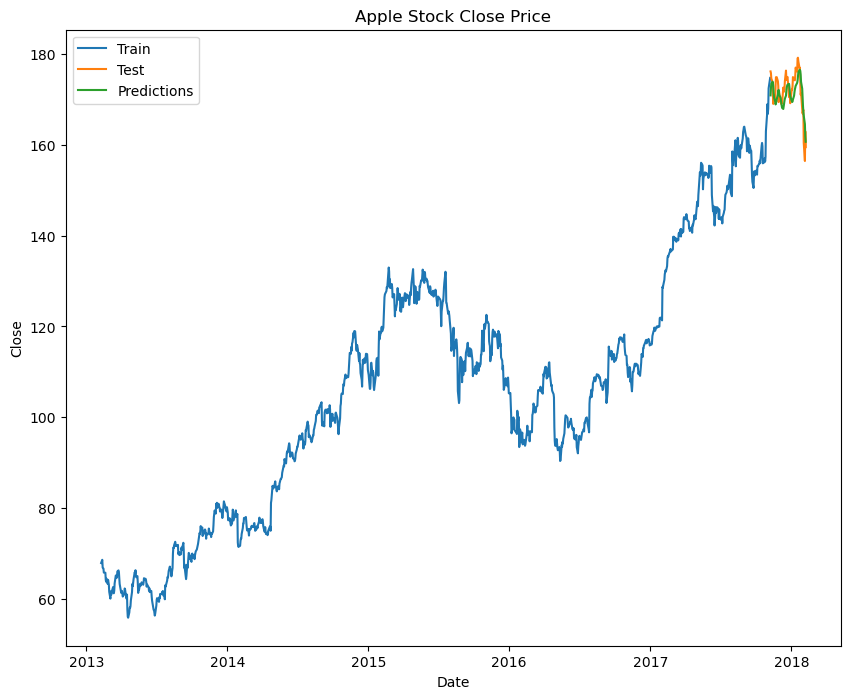

In [53]:
train = apple[:training]
test = apple[training:]
test['Predictions'] = predictions

plt.figure(figsize=(10,8))
plt.plot(train['date'], train['close'])
plt.plot(test['date'], test[['close','Predictions']])
plt.title('Apple Stock Close Price')
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend(['Train', 'Test', 'Predictions'])

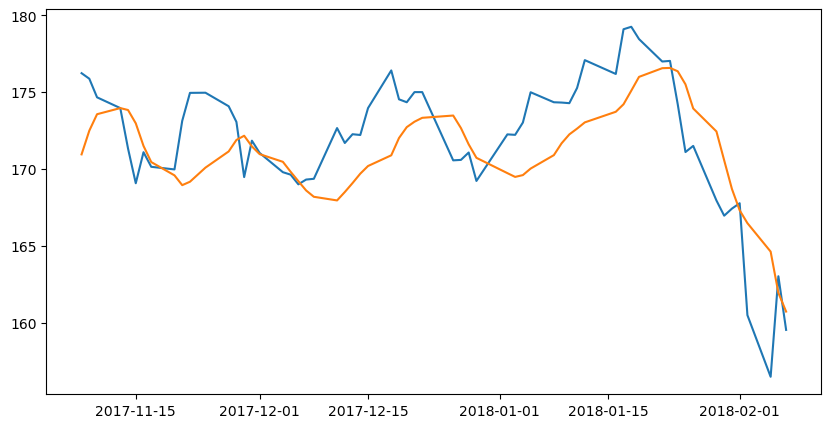

In [55]:
plt.figure(figsize=(10,5))
plt.plot(test['date'], test[['close','Predictions']])

In [1]:
print(os.getcwd())

/home/440c0116-d3b1-47d0-a23f-e03ae5d7a6b1/practice/Side projects


In [5]:
os.chdir("/Users/yunwaddyoo/Desktop/Projects/StockPricePrediction")

FileNotFoundError: [Errno 2] No such file or directory: '/Users/yunwaddyoo/Desktop/Projects/StockPricePrediction'